In [2]:
!pip install transformers==3.0.0

     |████████████████████████████████| 757kB 17.4MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 3.0MB 51.9MB/s 
     |████████████████████████████████| 1.2MB 45.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=dfa1b877dc3324506cc28b9dcb32338b25d95d351d808994d856fd58be89ed2c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#Get rid of annoying tensorflow warnings
import logging
logging.getLogger().setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from transformers import AdamW, RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import os
import sys
from torch import nn, optim
from torch.nn import functional as F
import json

In [4]:
class RoBERTa_BiLSTM(nn.Module):
    def __init__(self, num_classes, num_layers, hidden_dim, seq_length):
        super(RoBERTa_BiLSTM, self).__init__()
        self.lstm_size = hidden_dim
        self.embedding_dim = 768 # weird, but it's the size of the RoBERTa hidden state/vectors, so we're fine
        self.num_layers = num_layers # weird, maybe?
        self.num_classes = num_classes
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2, batch_first=True, bidirectional=True
        )
        self.downsample = nn.Linear(2*self.lstm_size + self.embedding_dim , self.lstm_size)
        #self.pooling = nn.MaxPool1d(1, self.lstm_size)
        self.pooling = nn.MaxPool1d(seq_length-1)
        self.fc = nn.Linear(self.lstm_size , self.num_classes)

    def forward(self, init_state, input_ids, attention_mask):
        embed = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = embed[0] # batch_size, seq_length, hidden_size
        embeddings = hidden_state[:, 1:]
        output, h_state = self.lstm(embeddings, init_state)
        ## concatenation
        #print(output.shape)
        #print(embeddings.shape)
        cat = torch.cat((output,embeddings),2)
        #print(cat.shape)
        state = self.downsample(cat) # y.size() = (batch_size, num_sequences, hidden_size)
        #print(state.shape)
        state = state.permute(0, 2, 1) # y.size() = (batch_size, hidden_size, num_sequences)
        #print(state.shape)
        state = self.pooling(state) # y.size() = (batch_size, hidden_size, 1)
        #state = F.max_pool1d(state, state.size()[2])
        #print(state.shape)
        state = state.squeeze(2)
        #print(state.shape)
        logits = self.fc(state)
        #print(logits.shape)
        return logits

    def init_state(self, batch_size=1):
        return (torch.zeros(2*self.num_layers, batch_size, self.lstm_size),
            torch.zeros(2*self.num_layers, batch_size, self.lstm_size))

In [5]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
def Extract_Headlines():
    #Open Sarcasm JSON File
    #f = open ('Sarcasm_Headlines_Dataset_v2_Copy.json', "r")
    f = open ('/content/Sarcasm_Headlines_Dataset_v2.json', "r")
    data = json.loads(f.read())
    f.close()
    labels = [] # list of correct labels
    headlines = [] #list of headlines

    max_length = 0
    #get data from file
    for item in data:
        label = int(item['is_sarcastic'])
        headline = item['headline']
        labels.append(label)
        headlines.append(headline)
        if len(headline.split()) > max_length:
            max_length = len(headline.split())
    #convert to numpy array before use
    return labels, headlines, max_length

In [22]:
#pick batch size and number of epochs
def Run_Model(device, batch_size, num_epochs, learningrate=2e-5):

    gold_labels, sentences, MAX_LEN  = Extract_Headlines()

    #number of classes
    num_classes = 2
    MAX_LEN = 64

    # model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes, output_hidden_states=True)
    model = RoBERTa_BiLSTM(num_classes=2, num_layers=2, hidden_dim=64, seq_length=MAX_LEN)
    tokenizer =  RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

    # print(MAX_LEN)
    # MAX_LEN += 20 # used to compensate for tokenization of conjunctions and punctuation

    # sentences = sentences[0:2000]
    # gold_labels = gold_labels[0:2000]

    #tokenize
    encoded_inputs = tokenizer(sentences, padding='max_length', truncation=True, max_length=MAX_LEN)

    input_ids = encoded_inputs["input_ids"]
    attention_masks = encoded_inputs["attention_mask"]


    #Split data into train/test/validation
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, gold_labels, random_state=2020, test_size=0.4)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2020, test_size=0.4)

    temp_val = validation_inputs
    validation_inputs, test_inputs, validation_labels, test_labels = train_test_split(temp_val, validation_labels, random_state=2020, test_size=0.5)
    validation_masks,test_masks, _, _ = train_test_split(validation_masks, temp_val, random_state=2020, test_size=0.5)

    #Package data into dataloaders
    train_inputs = torch.tensor(train_inputs)
    train_labels = torch.tensor(train_labels)
    train_masks = torch.tensor(train_masks)

    validation_inputs = torch.tensor(validation_inputs)
    validation_labels = torch.tensor(validation_labels)
    validation_masks = torch.tensor(validation_masks)

    test_inputs = torch.tensor(test_inputs)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_masks)

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size*4)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size*4)

    #send model to GPU
    model.to(device)

    #Set paramters and optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learningrate)
    #Scheduler is optional
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

    #keep track of loss for plotting
    train_loss_set = []
    epochs = num_epochs
    criterion = nn.CrossEntropyLoss()

    #training loop
    for epoch in trange(epochs, desc="Epoch"):
        model.train()

        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0,0

        for step, batch in enumerate(train_dataloader):

            batch = tuple(t.to(device) for t in batch)
            
            b_input_ids, b_input_mask, b_labels = batch
            state_h, state_c = model.init_state(batch_size=b_labels.shape[0])
            state_h = state_h.to(device)
            state_c = state_c.to(device)
            optimizer.zero_grad()

            b_input_ids = b_input_ids.clone().detach().to(device).long()
            outputs = model((state_h, state_c), b_input_ids, attention_mask=b_input_mask)
            #print(outputs.shape)
            #loss = criterion(outputs.transpose(1,2), b_labels)
            #loss = criterion(outputs, b_labels)
            loss = criterion(outputs.view(-1, 2),b_labels.view(-1))
            # loss, logits, states = outputs
            # print(outputs)
            train_loss_set.append(loss.item())
            loss.backward()
            optimizer.step()
            #scheduler.step()

            #gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        print(" train loss: {}".format(tr_loss/nb_tr_steps))
        #plot training loss
        plt.figure(figsize=(15,8))
        plt.title("Training loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.plot(train_loss_set)
        #plt.show()


        # Model Validation
        model.eval()

        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            state_h, state_c = model.init_state(batch_size=b_labels.shape[0])
            state_h = state_h.to(device)
            state_c = state_c.to(device)
            b_input_ids = b_input_ids.clone().detach().to(device).long()
            with torch.no_grad():
                logits = model((state_h, state_c), b_input_ids, attention_mask=b_input_mask)
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            tmp_eval_accuracy = flat_accuracy(logits, label_ids)
            eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1
        print("validation accuracy: {}".format(eval_accuracy/nb_eval_steps))

        #add code here to save model to file if it has better performance than before
    #Test phase
    model.eval()

    logits_list = []
    labels_list = []

    for batch in test_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      state_h, state_c = model.init_state(batch_size=b_labels.shape[0])
      state_h = state_h.to(device)
      state_c = state_c.to(device)
      with torch.no_grad():
        logits = model((state_h, state_c), b_input_ids, attention_mask=b_input_mask)
      logits_list.append(logits)
      labels_list.append(b_labels)
    # Flattened list of logits and the corresponding labels
    logits_list = torch.cat(logits_list)
    labels_list = torch.cat(labels_list)
    softmaxes = F.softmax(logits_list, dim=1)
    _, predictions_list = torch.max(softmaxes, dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_list.detach().cpu().numpy(),predictions_list.detach().cpu().numpy(), average='weighted')
    acc = accuracy_score(labels_list.detach().cpu().numpy(), predictions_list.detach().cpu().numpy())
    print('F1 Score: {}, Precision: {}, Recall: {}, Accuracy: {}'.format(f1, precision,recall,acc ))

    return model

In [8]:
def Predict_Sample(device, model, sentence, max_len=100):
    tokenizer =  RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

    inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")
    input_id = inputs["input_ids"]
    input_mask = inputs["attention_mask"]
    input_id = torch.tensor(input_id)
    input_mask = torch.tensor(input_mask)
    model.eval()
    state_h, state_c = model.init_state(batch_size=1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    logits = model((state_h, state_c), input_id.clone().detach().to(device).long(), attention_mask=input_mask.to(device))
    prediction = logits
    softmax_logits = F.softmax(prediction, dim=1)
    score, predicted = softmax_logits.max(1)
    print('The predicted score for your input sentence "{}"  is Class {} with confidence: {}'.format(sentence,predicted.item(), score.item()))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
%whos

Variable                           Type        Data/Info
--------------------------------------------------------
AdamW                              type        <class 'transformers.optimization.AdamW'>
DataLoader                         type        <class 'torch.utils.data.dataloader.DataLoader'>
Extract_Headlines                  function    <function Extract_Headlines at 0x7f483a482170>
F                                  module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Predict_Sample                     function    <function Predict_Sample at 0x7f483a4a33b0>
RandomSampler                      type        <class 'torch.utils.data.sampler.RandomSampler'>
RoBERTa_BiLSTM                     type        <class '__main__.RoBERTa_BiLSTM'>
RobertaForSequenceClassification   type        <class 'transformers.mode<...>rSequenceClassification'>
RobertaModel                       type        <class 'transformers.mode<...>ng_roberta.RobertaModel'>
RobertaTokenizer              

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

 train loss: 0.2800159561485746


Epoch:  20%|██        | 1/5 [04:41<18:46, 281.54s/it]

validation accuracy: 0.9281250000000001
 train loss: 0.14458519621788524


Epoch:  40%|████      | 2/5 [09:22<14:04, 281.36s/it]

validation accuracy: 0.9314236111111107
 train loss: 0.08263489867987331


Epoch:  60%|██████    | 3/5 [14:02<09:21, 280.91s/it]

validation accuracy: 0.9182291666666664
 train loss: 0.05492209709742474


Epoch:  80%|████████  | 4/5 [18:41<04:40, 280.24s/it]

validation accuracy: 0.921875
 train loss: 0.03990655809435091


Epoch: 100%|██████████| 5/5 [23:18<00:00, 279.73s/it]

validation accuracy: 0.9053819444444444


F1 Score: 0.9021408041534885, Precision: 0.911128909216631, Recall: 0.9028651292802237, Accuracy: 0.9028651292802237


RoBERTa_BiLSTM(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, ele

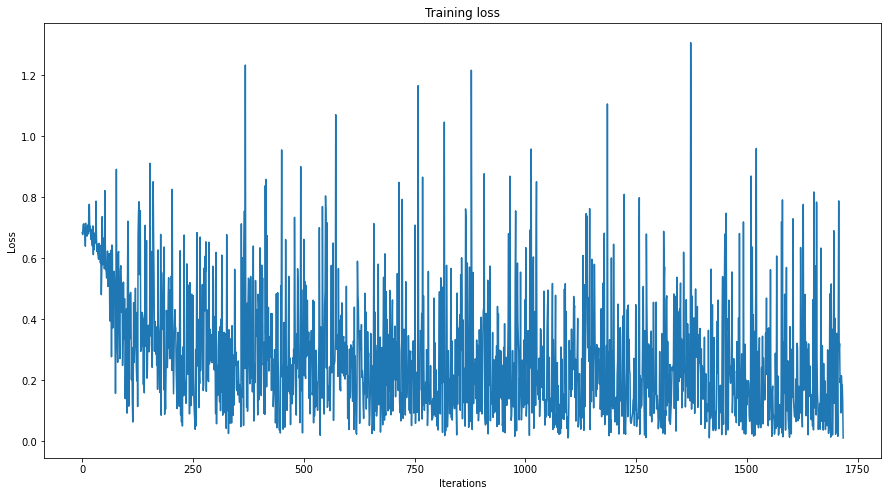

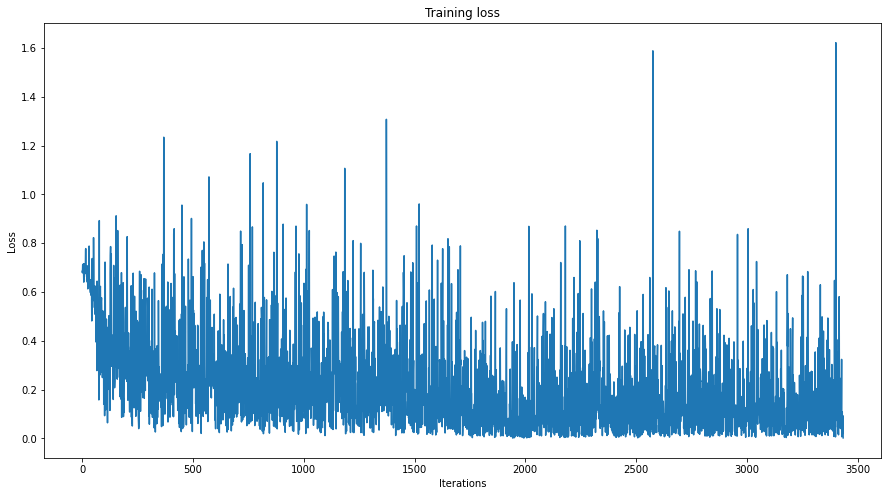

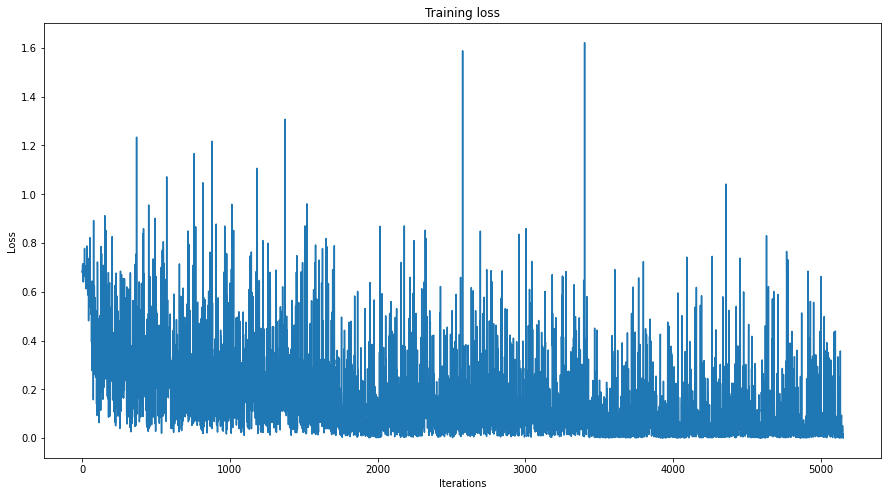

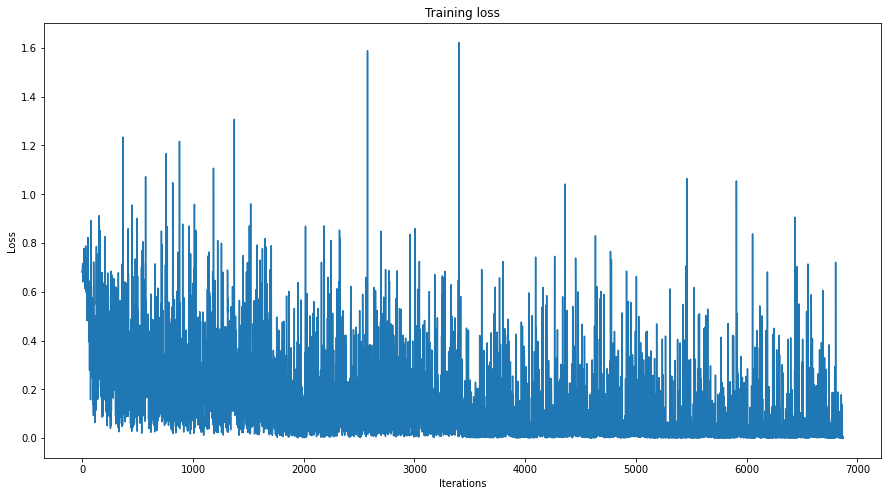

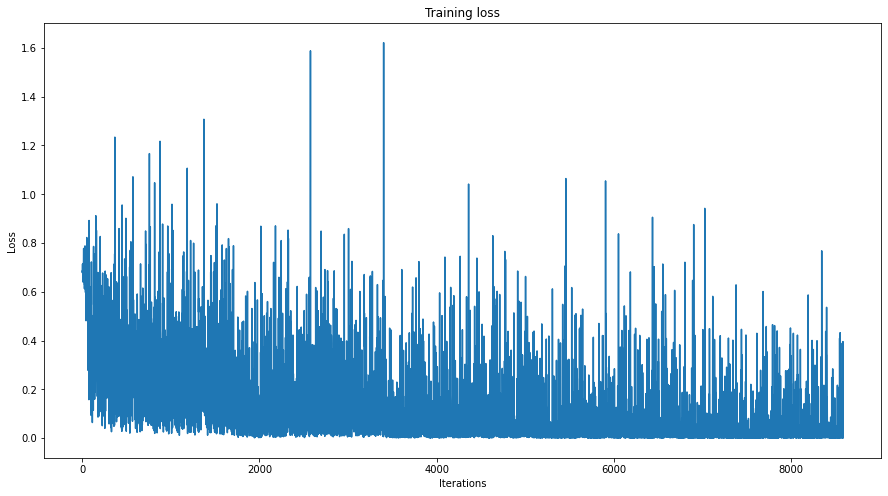

In [23]:
Run_Model(device, batch_size=10, num_epochs=2, learningrate=2e-5)